# Transfer Learning Job Profiles

The following graphs and statistics capture the profile of the transfer learning experiments.

In [196]:
# NOTEBOOK VARIABLES

experiment = "unsharded"
clusters_file = "clusters.csv"

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

dir_prefix = "experiment_data/job_profiles"
clusters_df = pd.read_csv(f"{dir_prefix}/{clusters_file}", header=0)
tasks_df = pd.read_csv(f"{dir_prefix}/{experiment}.csv", header=1)

tasks_df

,name,begin,end,time_seconds
0,Experiment,1,2394445,2394.44
1,CentroidModel;run(mongoUri=mongodb://lattice-1...,2113,738200,736.09
2,CentroidModel;run(mongoUri=mongodb://lattice-1...,2114,733488,731.37
3,CentroidModel;run(mongoUri=mongodb://lattice-1...,2114,742899,740.79
4,CentroidModel;run(mongoUri=mongodb://lattice-1...,2115,736176,734.06
...,...,...,...,...
6350,ClusterLRModels;Evaluate RMSE;gisJoin=G0500570...,2392561,2392757,0.20
6351,ClusterLRModels;Filter + split test/train + LR...,2392757,2393395,0.64
6352,ClusterLRModels;Evaluate RMSE;gisJoin=G4500850...,2393395,2393594,0.20
6353,ClusterLRModels;Filter + split test/train + LR...,2393594,2394201,0.61


In [198]:
def human_time(difference_ms):
    return datetime.timedelta(milliseconds=difference_ms)

class Cluster:
    
    def __init__(self, cluster_id):
        self.id = cluster_id
        self.gis_joins = []
        self.center_gis_join = ""
        

class Task:
    
    def __init__(self, task_id, name, begin, end, time_seconds, gis_join="", cluster_id=-1):
        self.id = task_id
        self.name = name
        self.begin = begin
        self.end = end
        self.time_seconds = time_seconds
        self.gis_join = gis_join
        self.cluster_id = cluster_id
        
    def __repr__(self):
        return repr(f"Task: id={self.id}, name={self.name}, begin={self.begin}, end={self.end}, time_seconds={self.time_seconds}")
    
    
class CentroidModelTasks:
    
    def __init__(self):
        self.run_tasks = []
        self.persist_tasks = []
        self.fit_tasks = []
        self.evaluate_tasks = []
        
        
class ClusterLRModelTasks:
    
    def __init__(self):
        self.run_tasks = {}
        self.persist_tasks = {}
        self.filter_fit_tasks = {}
        self.evaluate_tasks = {}
        
        

In [199]:
experiment = None
centroid_model_tasks = CentroidModelTasks()
cluster_lr_model_tasks = ClusterLRModelTasks()
clusters = {}

In [200]:
for i, row in clusters_df.iterrows():
    cluster_id = row["cluster_id"]
    if cluster_id not in clusters:
        clusters[cluster_id] = Cluster(cluster_id)
    
    if row["is_center"]:
        clusters[cluster_id].center_gis_join = row["gis_join"]
    else:
        clusters[cluster_id].gis_joins.append(row["gis_join"])
        

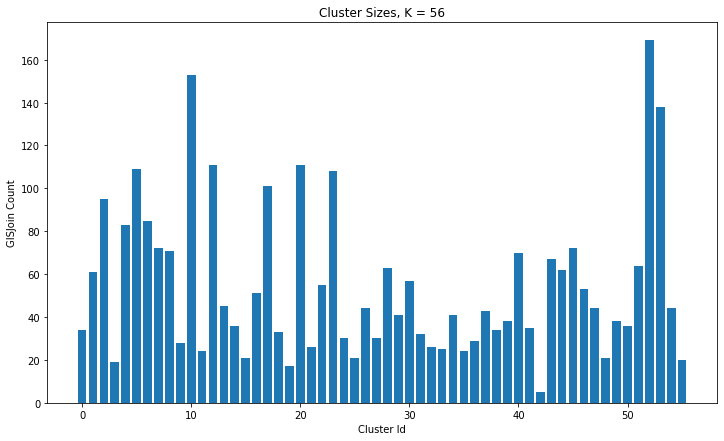

In [201]:
# ---- Plot Clusters Bar Chart -----

cluster_sizes = [len(clusters[cluster_id].gis_joins)+1 for cluster_id in clusters]
plt.figure(figsize=(12,7))
plt.bar(range(0, len(clusters)), cluster_sizes)
plt.title("Cluster Sizes, K = 56")
plt.xlabel("Cluster Id")
plt.ylabel("GISJoin Count")
plt.show()

In [202]:
for i, row in tasks_df.iterrows():
    if (i == 0):
        experiment = Task(i, row["name"], row["begin"], row["end"], row["time_seconds"])
    else:
        parts = row["name"].split(";")
        task_type = parts[0]
        task_name = parts[1]
        task_gis_join = parts[2][len("gisJoin=")+1:]
        task_cluster_id = str(parts[3][len("clusterId="):])
        
        new_task = Task(i, task_name, row["begin"], row["end"], row["time_seconds"], 
                        gis_join=task_gis_join, cluster_id=task_cluster_id)
        
        if (task_type == "CentroidModel"):
            if ("run(" in task_name):
                centroid_model_tasks.run_tasks.append(new_task)
            elif ("Persist" in task_name):
                centroid_model_tasks.persist_tasks.append(new_task)
            elif ("Split" in task_name):
                centroid_model_tasks.fit_tasks.append(new_task)
            else:
                centroid_model_tasks.evaluate_tasks.append(new_task)
        else:
            
            if ("run(" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.run_tasks:
                    cluster_lr_model_tasks.run_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.run_tasks[task_cluster_id].append(new_task)
                    
            elif ("Cluster" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.persist_tasks:
                    cluster_lr_model_tasks.persist_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.persist_tasks[task_cluster_id].append(new_task)
                    
            elif ("Filter" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.filter_fit_tasks:
                    cluster_lr_model_tasks.filter_fit_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.filter_fit_tasks[task_cluster_id].append(new_task)
                    
            elif ("Evaluate" in task_name):
                
                if task_cluster_id not in cluster_lr_model_tasks.evaluate_tasks:
                    cluster_lr_model_tasks.evaluate_tasks[task_cluster_id] = [new_task]
                else:
                    cluster_lr_model_tasks.evaluate_tasks[task_cluster_id].append(new_task)
        

Total time taken to train/evaluate 56 centroid models: 0:12:27.490000


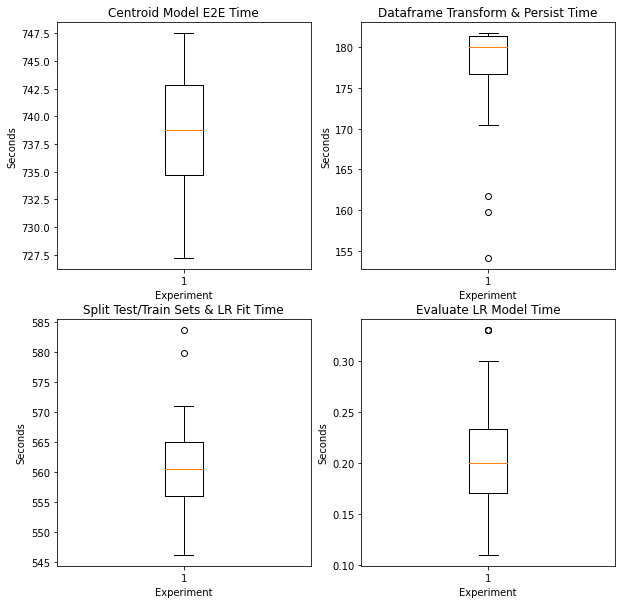

In [203]:
# ---- Centroid Models Plotting -----

centroid_run_tasks = [task.time_seconds for task in centroid_model_tasks.run_tasks]
centroid_persist_tasks = [task.time_seconds for task in centroid_model_tasks.persist_tasks]
centroid_fit_tasks = [task.time_seconds for task in centroid_model_tasks.fit_tasks]
centroid_eval_tasks = [task.time_seconds for task in centroid_model_tasks.evaluate_tasks]

total_centroid_time = human_time(centroid_model_tasks.evaluate_tasks[-1].end 
                                 - centroid_model_tasks.run_tasks[0].begin)

print("Total time taken to train/evaluate 56 centroid models:", total_centroid_time)


# Create a figure
figure, axis = plt.subplots(2, 2, figsize=(10,10))


# For Total End-to-End Time
axis[0, 0].boxplot(centroid_run_tasks)
axis[0, 0].set_title("Centroid Model E2E Time")
axis[0, 0].set_ylabel("Seconds")
axis[0, 0].set_xlabel("Experiment")
  
# For Persist Task
axis[0, 1].boxplot(centroid_persist_tasks)
axis[0, 1].set_title("Dataframe Transform & Persist Time")
axis[0, 1].set_ylabel("Seconds")
axis[0, 1].set_xlabel("Experiment")
  
# For Split Test/Train Data and LR Fit
axis[1, 0].boxplot(centroid_fit_tasks)
axis[1, 0].set_title("Split Test/Train Sets & LR Fit Time")
axis[1, 0].set_ylabel("Seconds")
axis[1, 0].set_xlabel("Experiment")
  
# For Evaluate LR Model
axis[1, 1].boxplot(centroid_eval_tasks)
axis[1, 1].set_title("Evaluate LR Model Time")
axis[1, 1].set_ylabel("Seconds")
axis[1, 1].set_xlabel("Experiment")

# show plot
plt.show()

Text(0.5, 0, 'Experiment')

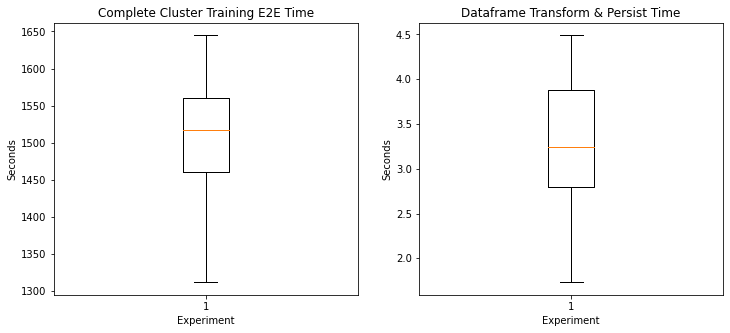

In [204]:
# ---- Cluster Transfer Learning Model Plotting -----

# plt.figure(figsize=(10,7))

clusters_run_time_seconds = [val[0].time_seconds for val in cluster_lr_model_tasks.run_tasks.values()]
clusters_persist_seconds  = [val[0].time_seconds for val in cluster_lr_model_tasks.persist_tasks.values()]
    

# Create a figure
figure, axis = plt.subplots(1, 2, figsize=(12,5))

# For Cluster Training End-to-End Time
axis[0].boxplot(clusters_run_time_seconds)
axis[0].set_title("Complete Cluster Training E2E Time")
axis[0].set_ylabel("Seconds")
axis[0].set_xlabel("Experiment")
  
# For Dataframe Transform & Persist
axis[1].boxplot(clusters_persist_seconds)
axis[1].set_title("Dataframe Transform & Persist Time")
axis[1].set_ylabel("Seconds")
axis[1].set_xlabel("Experiment")


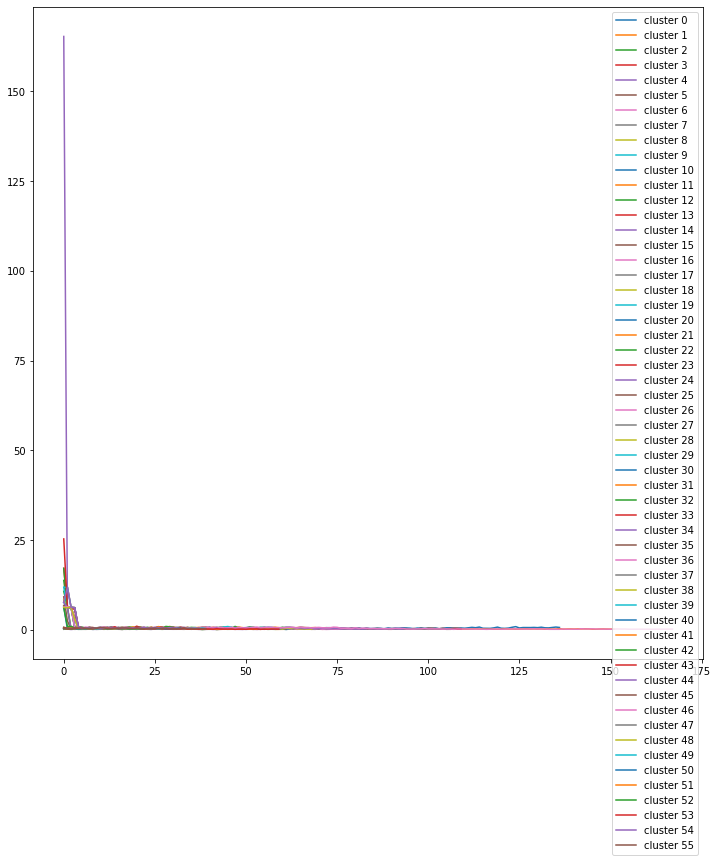

In [205]:
plt.figure(figsize=(12,12))
for i in range(0,56):
    cluster_key = str(i)
    cluster_eval_times = [val.time_seconds for val in cluster_lr_model_tasks.evaluate_tasks[cluster_key]]
    plt.plot(cluster_eval_times, label=f"cluster {i}")

plt.legend()
plt.show()